In [48]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Data Processing
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
import os
os.environ["PATH"] += os.pathsep + 'Users/xxd/anaconda3/lib/python3.9/site-packages/sphinx/templates/graphviz'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# preparing data
from sklearn.decomposition import PCA
from methods import *
from models import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn


model_name = "VAE"
DATASET = '1'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = False
REMOVE_NOISE_THRESHOLD = 8
DENOISE = False
NOISE_FACTOR = 0.1
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
NORMALIZATION_SCHEME = 'standard_scaling'
LATENT_DIM = 4
HIDDEN_DIM = 32
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-4
SIGMA = 1e-6
EPOCHS = 8000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if DATASET == '1':
    raw_data_network= np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data_network = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data_medical = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data_medical = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == '2':
    raw_data_network = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data_network = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data_medical = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data_medical = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #raw_data = np.concatenate((np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=0)
    anomalous_data_medical = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]

train_data, validation_data, test_data, anomalous_data_network = preProcessData_OneClass(raw_data_network, anomalous_data_network, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, cross_validation=CROSS_VALIDATION_SHUFFLE)
normal_data_network = np.concatenate((train_data, validation_data, test_data), axis=0)


train_data, validation_data, test_data, anomalous_data_medical = preProcessData_OneClass(raw_data_medical, anomalous_data_medical, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA, normalization_scheme=NORMALIZATION_SCHEME,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, cross_validation=CROSS_VALIDATION_SHUFFLE)
normal_data_medical = np.concatenate((train_data, validation_data, test_data), axis=0)

train_n_network, test_n_network, train_n_medical, test_n_medical = train_test_split(normal_data_network, normal_data_medical, train_size=0.8)
train_a_network, test_a_network, train_a_medical, test_a_medical = train_test_split(anomalous_data_network, anomalous_data_medical, train_size=0.8)

Train data shape after trim:  (8005, 9)
Train data shape after filter corrcoef:  (8005, 4)
Normalization scheme:  quantile_transform_uniform
Train data shape after normalize:  (8005, 4)
Train data shape after trim:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
Normalization scheme: standard scaling
Train data shape after normalize:  (8005, 7)


In [50]:
# use VAE to generate from noise to train
criterion = nn.MSELoss(reduction='sum')

train_n_network, train_n_medical = toTorchTensor(device, train_n_network, train_n_medical)
NUM_FEATURE_NETWORK = len(train_n_network[0])
model_network = VAE(NUM_FEATURE_NETWORK, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
# train
loss_array = train(model_network, 'SGD', EPOCHS, train_n_network, train_n_network, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e2)
#torch.save(model_network.state_dict(), '../model/param_VAE')

epoch : 1/8000, loss = 1.147486
epoch : 2/8000, loss = 0.874264
epoch : 3/8000, loss = 0.663891
epoch : 4/8000, loss = 0.514432
epoch : 5/8000, loss = 0.428910
epoch : 6/8000, loss = 0.393222
epoch : 7/8000, loss = 0.370945
epoch : 8/8000, loss = 0.359465
epoch : 9/8000, loss = 0.354613
epoch : 10/8000, loss = 0.348785
epoch : 11/8000, loss = 0.344911
epoch : 12/8000, loss = 0.342495
epoch : 13/8000, loss = 0.343174
epoch : 14/8000, loss = 0.340168
epoch : 15/8000, loss = 0.339873
epoch : 16/8000, loss = 0.339378
epoch : 17/8000, loss = 0.338442
epoch : 18/8000, loss = 0.337864
epoch : 19/8000, loss = 0.337393
epoch : 20/8000, loss = 0.336236
epoch : 21/8000, loss = 0.336974
epoch : 22/8000, loss = 0.336170
epoch : 23/8000, loss = 0.337576
epoch : 24/8000, loss = 0.336729
epoch : 25/8000, loss = 0.336140
epoch : 26/8000, loss = 0.335498
epoch : 27/8000, loss = 0.334425
epoch : 28/8000, loss = 0.333991
epoch : 29/8000, loss = 0.333016
epoch : 30/8000, loss = 0.332085
epoch : 31/8000, lo

In [51]:
NUM_FEATURE_medical = len(train_n_medical[0])
model_medical = VAE(NUM_FEATURE_medical, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
# train
loss_array = train(model_medical, 'SGD', EPOCHS, train_n_medical, train_n_medical, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e3)

epoch : 1/8000, loss = 8.769746
epoch : 2/8000, loss = 5.799190
epoch : 3/8000, loss = 5.347957
epoch : 4/8000, loss = 4.585011
epoch : 5/8000, loss = 4.310381
epoch : 6/8000, loss = 4.279405
epoch : 7/8000, loss = 4.072516
epoch : 8/8000, loss = 4.060635
epoch : 9/8000, loss = 3.630058
epoch : 10/8000, loss = 3.762543
epoch : 11/8000, loss = 3.047100
epoch : 12/8000, loss = 2.989632
epoch : 13/8000, loss = 2.863932
epoch : 14/8000, loss = 2.616983
epoch : 15/8000, loss = 2.542585
epoch : 16/8000, loss = 2.437362
epoch : 17/8000, loss = 2.807525
epoch : 18/8000, loss = 2.390774
epoch : 19/8000, loss = 2.294580
epoch : 20/8000, loss = 2.337531
epoch : 21/8000, loss = 2.226491
epoch : 22/8000, loss = 2.183636
epoch : 23/8000, loss = 2.115016
epoch : 24/8000, loss = 2.048715
epoch : 25/8000, loss = 1.978334
epoch : 26/8000, loss = 1.882235
epoch : 27/8000, loss = 1.818063
epoch : 28/8000, loss = 1.747390
epoch : 29/8000, loss = 1.690249
epoch : 30/8000, loss = 1.649695
epoch : 31/8000, lo

In [52]:
generation_size = 200000
mu, scale = 10, 10
random_choices = [-1, 1]
z_p = torch.normal(torch.ones(generation_size, LATENT_DIM)*mu*torch.tensor(np.random.choice(random_choices, size=(generation_size, LATENT_DIM), replace=True)), scale*torch.ones(generation_size, LATENT_DIM))
z_p = z_p.to(torch.float).to(device)
generated_data_network = model_network.decode(z_p)
z_p = torch.normal(torch.ones(generation_size, LATENT_DIM)*mu*torch.tensor(np.random.choice(random_choices, size=(generation_size, LATENT_DIM), replace=True)), scale*torch.ones(generation_size, LATENT_DIM))
z_p = z_p.to(torch.float).to(device)
generated_data_medical = model_medical.decode(z_p)
#generated_data = generated_data.detach().numpy()

In [53]:
""" import matplotlib.pyplot as plt

PERPLEXITY = 10
if True:
    model.eval()
    full_code = np.concatenate((train_data.detach().numpy(), generated_data.detach().numpy()), axis=0)
    full_label = [0 for _ in range(len(train_data))] + [1 for _ in range(len(generated_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# Plot the result of TSNE
fig3 = plt.figure(figsize = (6,6))
ax3 = fig3.add_subplot(1,1,1)
l1, l2 = len(train_data), len(generated_data)
ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.2).set_label('Anomalous data')
ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
ax3.set_xlabel('tSNE-1', fontsize = 12)
ax3.set_ylabel('tSNE-2', fontsize = 12)
ax3.legend() """

' import matplotlib.pyplot as plt\n\nPERPLEXITY = 10\nif True:\n    model.eval()\n    full_code = np.concatenate((train_data.detach().numpy(), generated_data.detach().numpy()), axis=0)\n    full_label = [0 for _ in range(len(train_data))] + [1 for _ in range(len(generated_data))]\n    from sklearn.manifold import TSNE\n\n    # We want to get TSNE embedding with 2 dimensions\n    n_components = 2\n    tsne = TSNE(n_components, perplexity=PERPLEXITY)\n    #print(full_data.shape)\n    tsne_code = tsne.fit_transform(full_code)\n# Plot the result of TSNE\nfig3 = plt.figure(figsize = (6,6))\nax3 = fig3.add_subplot(1,1,1)\nl1, l2 = len(train_data), len(generated_data)\nax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label(\'Normal data\')\nax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.2).set_label(\'Anomalous data\')\nax3.set_title((\'tSNE of codes (perplexity = \' + str(PERPLEXITY) + \'): \' + model_name), fontsize = 18)\nax3.set_xlabel(\'tSNE-1\', fonts

In [54]:
train_n_network, train_n_medical = train_n_network.detach().numpy(), train_n_medical.detach().numpy()

In [55]:
USE_ATTACK_SAMPLE = False

train_X_network = np.concatenate((train_n_network, generated_data_network.detach().numpy()), axis=0)
train_Y_network = np.concatenate((np.zeros(len(train_n_network)), np.ones(generation_size)))
test_X_network, test_Y_network = np.concatenate((test_n_network, test_a_network), axis=0), np.concatenate((np.zeros(len(test_n_network)), np.ones(len(test_a_network))))

#full_data = np.concatenate((raw_data, anomalous_train), axis=0)
#full_label = np.concatenate((np.zeros(len(raw_data)), np.ones(len(anomalous_train))), axis=0)
if USE_ATTACK_SAMPLE:
    sample_size = 100
    attack_sample_X, attack_sample_Y = train_a_network[np.random.choice(np.arange(len(train_a_network)), sample_size, replace=False)], np.ones(sample_size)
    
    train_data1= train_n_network[:]
    for _ in range(1):
        train_data1 = np.concatenate((train_data1, train_n_network), axis=0)
    
    X_res, Y_res = SVMSMOTE().fit_resample(np.concatenate((train_data1, attack_sample_X), axis=0), np.concatenate((np.zeros(len(train_data1)), attack_sample_Y), axis=0))
    print('Data augmentation complete.')
    idc = Y_res == 1
    X_res, Y_res = X_res[idc], Y_res[idc]
    print(f'X_res size:{X_res.shape}')
    train_X_network, train_Y_network = np.concatenate((train_X_network, X_res), axis=0), np.concatenate((train_Y_network, Y_res), axis=0)
else:
    test_X_network, test_Y_network = np.concatenate((test_n_network, anomalous_data_network), axis=0), np.concatenate((np.zeros(len(test_n_network)), np.ones(len(anomalous_data_network))))

#normal_idc = Y_res == 0
#normal_res, anomalous_res = X_res[normal_idc], X_res[np.logical_not(normal_idc)]

rf = RandomForestClassifier(class_weight='balanced')
#rf = RandomForestClassifier()
#rf.fit(X_res, Y_res)
rf.fit(train_X_network, train_Y_network)

RandomForestClassifier(class_weight='balanced')

In [56]:
print(test_X_network.shape)
y_pred_network = rf.predict(test_X_network)
accuracy = accuracy_score(test_Y_network, y_pred_network)
precision, recall, f1 = precision_score(test_Y_network, y_pred_network), recall_score(test_Y_network, y_pred_network), f1_score(test_Y_network, y_pred_network)

print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")

(4715, 4)
Accuracy:  0.664475079533404
Precision: 0.9833333333333333
Recall: 0.23069403714565004
F1 score: 0.3737133808392716


In [57]:
USE_ATTACK_SAMPLE = False

train_X_medical = np.concatenate((train_n_medical, generated_data_medical.detach().numpy()), axis=0)
train_Y_medical = np.concatenate((np.zeros(len(train_n_medical)), np.ones(generation_size)))
test_X_medical, test_Y_medical = np.concatenate((test_n_medical, test_a_medical), axis=0), np.concatenate((np.zeros(len(test_n_medical)), np.ones(len(test_a_medical))))

#full_data = np.concatenate((raw_data, anomalous_train), axis=0)
#full_label = np.concatenate((np.zeros(len(raw_data)), np.ones(len(anomalous_train))), axis=0)
if USE_ATTACK_SAMPLE:
    sample_size = 100
    attack_sample_X, attack_sample_Y = train_a_medical[np.random.choice(np.arange(len(train_a_medical)), sample_size, replace=False)], np.ones(sample_size)
    
    train_data1= train_n_medical[:]
    for _ in range(1):
        train_data1 = np.concatenate((train_data1, train_n_medical), axis=0)
    
    X_res, Y_res = SVMSMOTE().fit_resample(np.concatenate((train_data1, attack_sample_X), axis=0), np.concatenate((np.zeros(len(train_data1)), attack_sample_Y), axis=0))
    
    print('Data augmentation complete.')
    idc = Y_res == 1
    X_res, Y_res = X_res[idc], Y_res[idc]
    print(f'X_res size:{X_res.shape}')
    train_X_medical, train_Y_medical = np.concatenate((train_X_medical, X_res), axis=0), np.concatenate((train_Y_medical, Y_res), axis=0)
else:
    test_X_medical, test_Y_medical = np.concatenate((test_n_medical, anomalous_data_medical), axis=0), np.concatenate((np.zeros(len(test_n_medical)), np.ones(len(anomalous_data_medical))))

#normal_idc = Y_res == 0
#normal_res, anomalous_res = X_res[normal_idc], X_res[np.logical_not(normal_idc)]

rf = RandomForestClassifier(class_weight='balanced')
#rf = RandomForestClassifier()
#rf.fit(X_res, Y_res)
rf.fit(train_X_medical, train_Y_medical)

RandomForestClassifier(class_weight='balanced')

In [58]:
print(test_X_medical.shape)
y_pred_medical = rf.predict(test_X_medical)
accuracy = accuracy_score(test_Y_medical, y_pred_medical)
precision, recall, f1 = precision_score(test_Y_medical, y_pred_medical), recall_score(test_Y_medical, y_pred_medical), f1_score(test_Y_medical, y_pred_medical)

print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")

(4715, 7)
Accuracy:  0.5963944856839872
Precision: 0.9798657718120806
Recall: 0.07135874877810362
F1 score: 0.13302961275626424


['SpO2' 'Pulse_Rate' 'SYS' 'DIA' 'Heart_rate' 'Resp_Rate' 'ST']


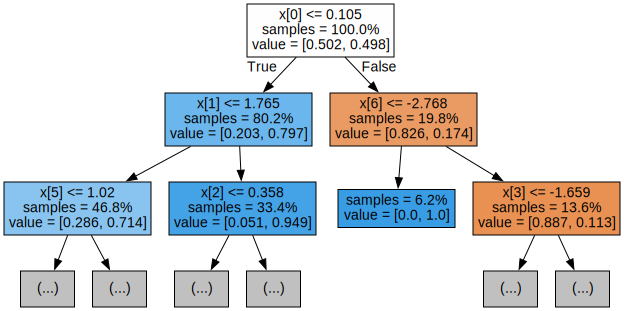

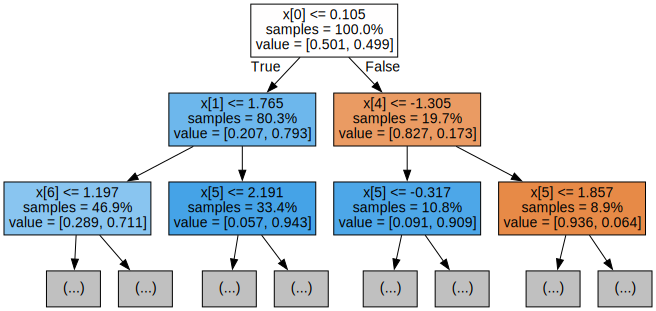

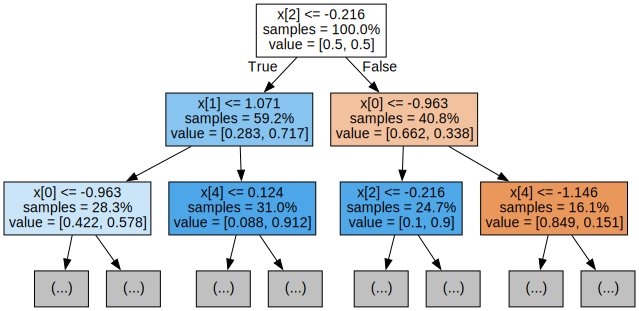

In [59]:
# Export the first three decision trees from the forest
features = np.genfromtxt('../data/medical_regular_data.csv', dtype='str', max_rows=1, delimiter=',')[:-1]
print(features)
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               #feature_names=features,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [60]:
if True:
    y_pred_combined = np.logical_or(y_pred_medical, y_pred_network)
    accuracy = accuracy_score(test_Y_network, y_pred_combined)
    precision, recall, f1 = precision_score(test_Y_medical, y_pred_combined), recall_score(test_Y_medical, y_pred_combined), f1_score(test_Y_medical, y_pred_combined)

    print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")

Accuracy:  0.6812301166489926
Precision: 0.9805309734513274
Recall: 0.270772238514174
F1 score: 0.4243584833397166
